In [1]:
!pip install lime
!pip install shap
import shap
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,RandomForestRegressor
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import time
import lime
from lime.lime_tabular import LimeTabularExplainer
import numpy as np
import seaborn as sns

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [2]:
import pandas as pd
import matplotlib.pyplot as plt

def preprocess_data(annotation_file, physiological_file):
    # Read annotation data
    annotation_data = pd.read_csv(annotation_file)

    # Classify emotion based on valence and arousal
    def classify_emotion(arousal, valence):
        arousal_bins = [-26225, -13112, 0, 13112, 26225]
        valence_bins = [-26225, -13112, 0, 13112, 26225]

        arousal_label = pd.cut([arousal], bins=arousal_bins,
                               labels=False, include_lowest=True)
        valence_label = pd.cut([valence], bins=valence_bins,
                               labels=False, include_lowest=True)

        return f'Partition_{arousal_label}_{valence_label}'
    
    annotation_data = annotation_data[annotation_data['video'].isin([7.0, 8.0])]

    annotation_data['Emotion_Partition'] = annotation_data.apply(
        lambda row: classify_emotion(row['arousal'], row['valence']), axis=1)

    # Define the rectangular partition
    rectangular_partition = {
        'arousal': (-3000, 3000), 'valence': (-3000, 3000)}
    
    # Assuming you have a DataFrame named 'annotation_data' with columns 'arousal', 'valence', and 'Emotion'
    annotation_data['Emotion'] = ''

    for index, row in annotation_data.iterrows():
        arousal = row['arousal']
        valence = row['valence']

        if -3000 <= arousal <= 3000 and -3000 <= valence <= 3000:
            annotation_data.loc[index, 'Emotion'] = 'Neutral'
        else:
            if -26225 <= arousal <= -13112:
                if -26225 <= valence <= -13112:
                    annotation_data.loc[index,
                                        'Emotion'] = 'Anxious or Dejected'
                elif -13112 <= valence <= 0:
                    annotation_data.loc[index, 'Emotion'] = 'Tired or Bored'
                elif 0 <= valence <= 13112:
                    annotation_data.loc[index, 'Emotion'] = 'Polite or Sleepy'
                else:
                    annotation_data.loc[index, 'Emotion'] = 'Relaxed or Calm'
            elif -13112 <= arousal <= 0:
                if -26225 <= valence <= -13112:
                    annotation_data.loc[index, 'Emotion'] = 'Miserable or Sad'
                elif -13112 <= valence <= 0:
                    annotation_data.loc[index,
                                        'Emotion'] = 'Worried or Apathetic'
                elif 0 <= valence <= 13112:
                    annotation_data.loc[index,
                                        'Emotion'] = 'Confident or Attentive'
                else:
                    annotation_data.loc[index, 'Emotion'] = 'Pleased or Glad'
            elif 0 <= arousal <= 13112:
                if -26225 <= valence <= -13112:
                    annotation_data.loc[index,
                                        'Emotion'] = 'Frustrated or Discontented'
                elif -13112 <= valence <= 0:
                    annotation_data.loc[index,
                                        'Emotion'] = 'Frustrated or Impatient'
                elif 0 <= valence <= 13112:
                    annotation_data.loc[index,
                                        'Emotion'] = 'Passionate or Amused'
                else:
                    annotation_data.loc[index,
                                        'Emotion'] = 'Delighted or Happy'
            else:
                if -26225 <= valence <= -13112:
                    annotation_data.loc[index,
                                        'Emotion'] = 'Distressed or Defiant'
                elif -13112 <= valence <= 0:
                    annotation_data.loc[index, 'Emotion'] = 'Tensed or Annoyed'
                elif 0 <= valence <= 13112:
                    annotation_data.loc[index,
                                        'Emotion'] = 'Aroused or Astonished'
                else:
                    annotation_data.loc[index,
                                        'Emotion'] = 'Excited or Adventurous'
                    
    # Scatter plot with color-coded partitions
    c = annotation_data['Emotion_Partition'].astype('category').cat.codes
    plt.scatter(annotation_data['valence'], annotation_data['arousal'],
                c=c, cmap='viridis', label='Other Partitions')

    # Draw vertical lines for Arousal partitions
    arousal_bins = [-26225, -13112, 0, 13112, 26225]
    for bin_value in arousal_bins[1:-1]:
        plt.axvline(x=bin_value, color='black', linestyle='--', linewidth=1)

    # Draw horizontal lines for Valence partitions
    valence_bins = [-26225, -13112, 0, 13112, 26225]
    for bin_value in valence_bins[1:-1]:
        plt.axhline(y=bin_value, color='black', linestyle='--', linewidth=1)

    # Create a mask for points inside the rectangular partition
    mask = (
        (annotation_data['arousal'] >= rectangular_partition['arousal'][0]) &
        (annotation_data['arousal'] <= rectangular_partition['arousal'][1]) &
        (annotation_data['valence'] >= rectangular_partition['valence'][0]) &
        (annotation_data['valence'] <= rectangular_partition['valence'][1])
    )

    # Scatter plot for points inside the rectangular partition with a different color
    plt.scatter(annotation_data.loc[mask,
                'valence'], annotation_data.loc[mask, 'arousal'], c='red', label='Rectangular Partition')

    plt.title(
        'Emotion Partitions based on Arousal and Valence with Extra Partition Rectangle')
    plt.xlabel('Arousal')
    plt.ylabel('Valence')
    plt.legend()
    plt.show()

    # Assuming you have a DataFrame named 'annotation_data' with columns 'arousal', 'valence', and 'Emotion'
    annotation_data_1 = annotation_data.drop('Emotion_Partition', axis=1)
    physiological_data = pd.read_csv(physiological_file)
    # Assuming you have a DataFrame named 'merged_data' with columns 'video_x', 'video_y', and 'time'

    annotation_data_1['jstime'] = annotation_data_1['jstime'].astype('int')
    physiological_data['daqtime'] = physiological_data['daqtime'].astype('int')

    annotation_data_1.rename(columns={"jstime": "time"}, inplace=True)

    physiological_data.rename(columns={"daqtime": "time"}, inplace=True)

    merged_data = pd.merge(
        annotation_data_1, physiological_data, on="time", how="left")

    return merged_data

# merged_data = preprocess_data(f'C:/Users/Kaushik/Documents/RESEARCH PAPERS/JOURNAL/journal/dataset/1-30_annotation/sub_{subject}.csv',
#                               f'C:/Users/Kaushik/Documents/RESEARCH PAPERS/JOURNAL/journal/dataset/1-30_physiological/sub_{subject}.csv')
    

In [3]:
# print(X_test[0:100])
# np.array(shap_values_RF_test).shape

In [4]:
# import pandas as pd

# def load_and_filter_annotation_data(annotation_path):
#     # Load the annotation data
#     annotation_data = pd.read_csv(annotation_path)
    
#     # Filter annotation data for video values 1.0 and 2.0
#     annotation_data = annotation_data[annotation_data['video'].isin([1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0])]
    
#     return annotation_data

# def load_physiological_data(physiological_path):
#     # Load the physiological data
#     physiological_data = pd.read_csv(physiological_path)
    
#     physiological_data = physiological_data[physiological_data['video'].isin([1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0])]
    
#     return physiological_data

# # Initialize empty DataFrames to hold all annotations and physiological data
# all_annotations = pd.DataFrame()
# all_physiological = pd.DataFrame()

# subjects = [7, 11, 12, 18, 23, 26, 27, 28, 29, 2, 8, 13, 24, 25]
# for subject in subjects:
#     print(f"Processing SUBJECT {subject}")
    
#     # Load and filter annotation data for the current subject
#     annotation_data = load_and_filter_annotation_data(
#         f'C:/Users/Kaushik/Documents/RESEARCH PAPERS/JOURNAL/journal/dataset/1-30_annotation/sub_{subject}.csv'
#     )
    
#     # Load physiological data for the current subject
#     physiological_data = load_physiological_data(
#         f'C:/Users/Kaushik/Documents/RESEARCH PAPERS/JOURNAL/journal/dataset/1-30_physiological/sub_{subject}.csv'
#     )
    
#     # Append the data to the respective DataFrames
#     all_annotations = pd.concat([all_annotations, annotation_data], ignore_index=True)
#     all_physiological = pd.concat([all_physiological, physiological_data], ignore_index=True)

# # Save the combined DataFrames to CSV files
# all_annotations.to_csv('C:/Users/Kaushik/Documents/RESEARCH PAPERS/JOURNAL/journal/dataset/all_25-29_annotations_merged.csv', index=False)
# all_physiological.to_csv('C:/Users/Kaushik/Documents/RESEARCH PAPERS/JOURNAL/journal/dataset/all_25-29_physiological_merged.csv', index=False)

# print("All subjects have been processed and merged into separate datasets.")

# # Categorize and save each video category in separate CSV files
# video_categories = {
#     "amusing": [1.0, 2.0],
#     "boring": [3.0, 4.0],
#     "relaxed": [5.0, 6.0],
#     "scary": [7.0, 8.0]
# }

# for category, videos in video_categories.items():
#     category_annotations = all_annotations[all_annotations['video'].isin(videos)]
#     category_physiological = all_physiological[all_physiological['video'].isin(videos)]
    
#     category_annotations.to_csv(f'C:/Users/Kaushik/Documents/RESEARCH PAPERS/JOURNAL/journal/dataset/{category}_25-29_annotations.csv', index=False)
#     category_physiological.to_csv(f'C:/Users/Kaushik/Documents/RESEARCH PAPERS/JOURNAL/journal/dataset/{category}_25-29_physiological.csv', index=False)

# print("Data has been categorized and saved into separate CSV files.")


Creating legend with loc="best" can be slow with large amounts of data.


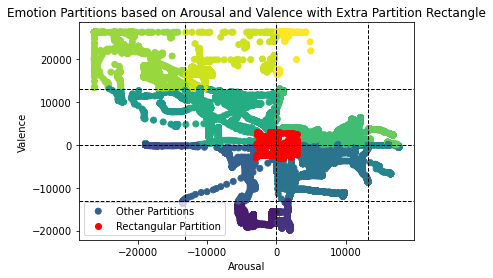

['Passionate or Amused' 'Confident or Attentive' 'Worried or Apathetic'
 'Pleased or Glad' 'Delighted or Happy' 'Anxious or Dejected'
 'Miserable or Sad' 'Frustrated or Impatient' 'Tensed or Annoyed'
 'Distressed or Defiant' 'Polite or Sleepy' 'Tired or Bored'
 'Frustrated or Discontented' 'Aroused or Astonished']
        valence  arousal  video_x                Emotion      ecg        bvp  \
2459     3017.0      8.0      7.0   Passionate or Amused -0.15274  34.811392   
2460     3069.0      8.0      7.0   Passionate or Amused  0.83290  34.908267   
2461     3113.0      8.0      7.0   Passionate or Amused  0.83290  34.753315   
2462     3165.0      8.0      7.0   Passionate or Amused  1.06288  34.598303   
2463     3213.0      4.0      7.0   Passionate or Amused  1.34214  34.927665   
...         ...      ...      ...                    ...      ...        ...   
427180 -23848.0  16920.0      7.0  Distressed or Defiant  0.78690  36.961677   
427181 -23848.0  16920.0      7.0  Distresse

In [5]:
#FOR 20-24 AGE CATEGORY all merged

import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder


# Preprocess data for the current subject
merged_data_1 = preprocess_data(
    f'C:/Users/Kaushik/Documents/RESEARCH PAPERS/JOURNAL/journal/dataset/scary_25-29_annotations.csv',
    f'C:/Users/Kaushik/Documents/RESEARCH PAPERS/JOURNAL/journal/dataset/scary_25-29_physiological.csv'
)
    

merged_data_1['valence'] = merged_data_1['valence'].fillna(method="ffill")
merged_data_1['arousal'] = merged_data_1['arousal'].fillna(method="ffill")
merged_data_1 = merged_data_1[merged_data_1['video_x'] == merged_data_1['video_y']]
merged_data_1 = merged_data_1[merged_data_1['Emotion'] != 'Neutral']
sub_data = merged_data_1.drop('time', axis=1)
print(sub_data['Emotion'].unique())
print(sub_data)
print(len(sub_data))
label_encoder = LabelEncoder()
X=sub_data.drop(['Emotion','valence','arousal','video_y','video_x'],axis=1)
y=sub_data['Emotion']
y_encoded = label_encoder.fit_transform(sub_data['Emotion'])
encoded_classes = label_encoder.classes_
y = y_encoded

print(len(X))
print(len(y))
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)





In [14]:
for i in range(1000):
    if y_test[i]==6:
        print(X_test.iloc[i])
        print(y_test[i])
        print(i)

ecg          0.691620
bvp         36.322411
gsr          9.296856
rsp         35.392372
skt         24.891522
emg_zygo     5.563250
emg_coru     5.358000
emg_trap    14.803500
Name: 401755, dtype: float64
6
1
ecg          1.079300
bvp         36.574238
gsr          6.887976
rsp         33.533940
skt         25.445428
emg_zygo     6.138250
emg_coru     8.314750
emg_trap     7.575500
Name: 183224, dtype: float64
6
5
ecg          0.800040
bvp         36.041516
gsr          7.037784
rsp         33.930787
skt         25.448949
emg_zygo     6.877500
emg_coru     9.588000
emg_trap     8.766500
Name: 381220, dtype: float64
6
9
ecg          0.658760
bvp         35.925302
gsr         18.423864
rsp         34.598679
skt         31.773333
emg_zygo     5.193750
emg_coru     7.781000
emg_trap     6.507750
Name: 424605, dtype: float64
6
13
ecg          1.302720
bvp         33.658803
gsr         19.196616
rsp         33.340319
skt         31.377180
emg_zygo     4.577750
emg_coru     7.288250
emg_trap 

Name: 402012, dtype: float64
6
533
ecg          0.806620
bvp         36.477363
gsr         10.223352
rsp         36.476496
skt         24.576017
emg_zygo     5.481250
emg_coru     5.563250
emg_trap     6.056000
Name: 419060, dtype: float64
6
535
ecg          0.836180
bvp         36.806725
gsr          6.895848
rsp         32.236868
skt         25.427907
emg_zygo     6.754250
emg_coru     8.356000
emg_trap     7.657750
Name: 184250, dtype: float64
6
542
ecg          0.721200
bvp         36.167459
gsr          6.978648
rsp         33.640414
skt         25.434906
emg_zygo     6.097250
emg_coru     8.684500
emg_trap     7.206000
Name: 182864, dtype: float64
6
549
ecg          0.878900
bvp         37.048823
gsr         12.663792
rsp         36.389349
skt         24.533932
emg_zygo     5.070500
emg_coru     5.645500
emg_trap     6.138250
Name: 424208, dtype: float64
6
551
ecg          0.964320
bvp         37.329718
gsr         44.169000
rsp         47.762725
skt         29.340331
emg_zygo   

TIME to interpret

 154.92719841003418 seconds


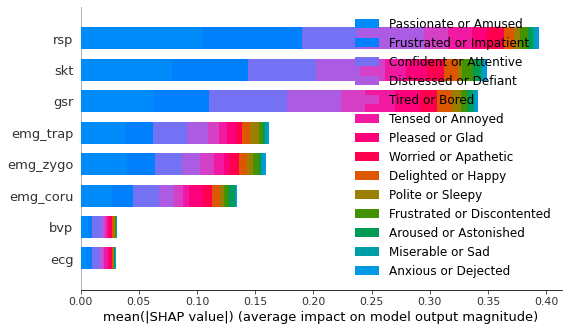

In [15]:
rf=RandomForestClassifier()
rf.fit(X_train,y_train)
t0 = time.time()
explainerRF = shap.TreeExplainer(rf)
shap_values_RF_test = explainerRF.shap_values(X_test[0:100])
t1 = time.time()
timeit=t1-t0
print("TIME to interpret\n\n",timeit, "seconds")
categorical_features = np.argwhere(np.array([len(set(X_train.values[:,x]))
for x in range(X_train.values.shape[1])]) <= 10).flatten()

class_names = encoded_classes
shap.summary_plot(shap_values_RF_test, X_test,class_names=class_names)


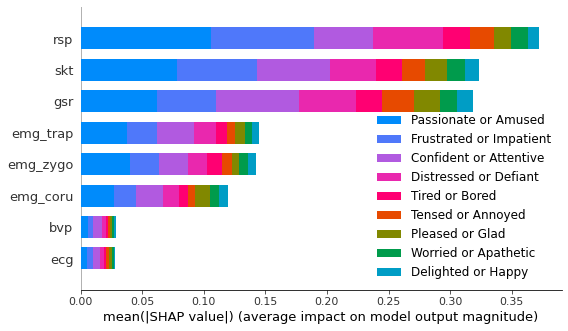

In [16]:
# Step 1: Sum the absolute SHAP values across features for each class
class_sums = np.sum(np.abs(shap_values_RF_test), axis=(1, 2))

# Step 2: Get the indices of the top N classes
top_class_indices = np.argsort(class_sums)[-9:]  # Change 6 to the number of classes you want to display

# Step 3: Select the SHAP values and class names for these top classes
shap_values_top_classes = [shap_values_RF_test[i] for i in top_class_indices]
class_names_top = [class_names[i] for i in top_class_indices]

# Step 4: Create the summary plot for the top classes
shap.summary_plot(shap_values_top_classes, X_test[0:100], class_names=class_names_top)


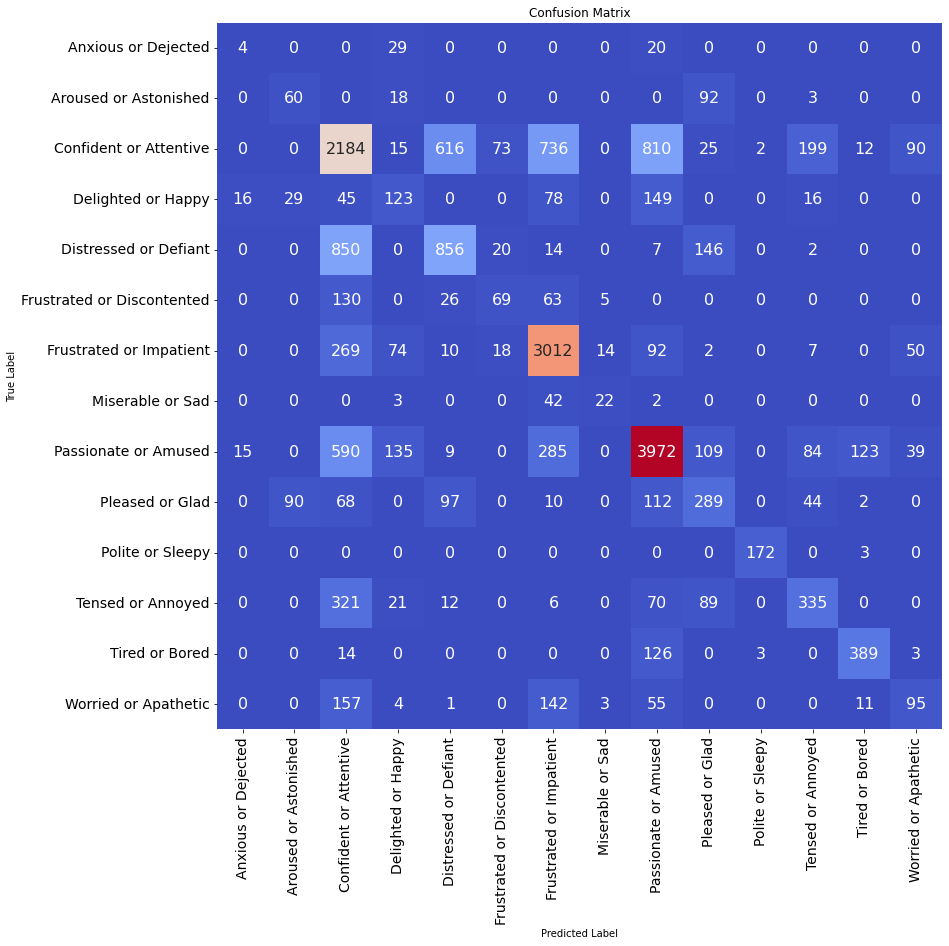

<Figure size 432x288 with 0 Axes>

In [17]:

y_pred = rf.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

# Extract unique labels from y_test
unique_labels = sorted(set(y_test))

# Create a filtered list of class names
filtered_class_names = [class_names[i] for i in unique_labels]

plt.figure(figsize=(13, 13))
sns.heatmap(cm, annot=True, fmt="d", cmap="coolwarm", cbar=False,
            xticklabels=filtered_class_names,
            yticklabels=filtered_class_names,
            annot_kws={"size": 16})
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()
plt.savefig("amusing_confusion_matrix.png", bbox_inches='tight', dpi=300)


0.5984292652681616


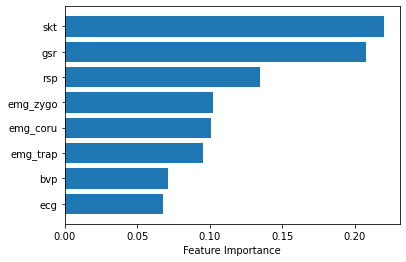

In [18]:
print(accuracy_score(y_test,y_pred))
feature_importances = rf.feature_importances_

# Sort features based on importance
sorted_idx = feature_importances.argsort()

# Plotting the feature importances
plt.barh(range(X_train.shape[1]), feature_importances[sorted_idx])
plt.yticks(range(X_train.shape[1]), X_train.columns[sorted_idx])
plt.xlabel('Feature Importance')
plt.show()

In [19]:
# for i in range(1000):
#     if y_test[i]==0:
#         print(X_test.iloc[i])
#         print(y_test[i])
#         print(i)

In [20]:
X_test.iloc[1]

ecg          0.691620
bvp         36.322411
gsr          9.296856
rsp         35.392372
skt         24.891522
emg_zygo     5.563250
emg_coru     5.358000
emg_trap    14.803500
Name: 401755, dtype: float64

In [21]:
print(encoded_classes)

['Anxious or Dejected' 'Aroused or Astonished' 'Confident or Attentive'
 'Delighted or Happy' 'Distressed or Defiant' 'Frustrated or Discontented'
 'Frustrated or Impatient' 'Miserable or Sad' 'Passionate or Amused'
 'Pleased or Glad' 'Polite or Sleepy' 'Tensed or Annoyed' 'Tired or Bored'
 'Worried or Apathetic']


In [22]:
instance_index = 1
print(X_test.iloc[instance_index])
print(class_names[y_test[instance_index]])
for i in range(len(class_names)):
    print(class_names[i])
    print(shap_values_RF_test[i][instance_index][:])

ecg          0.691620
bvp         36.322411
gsr          9.296856
rsp         35.392372
skt         24.891522
emg_zygo     5.563250
emg_coru     5.358000
emg_trap    14.803500
Name: 401755, dtype: float64
Frustrated or Impatient
Anxious or Dejected
[-2.80976370e-05 -3.08311510e-04  1.85471518e-03  2.82857945e-04
 -2.46992474e-03 -4.11846572e-03  2.37980747e-04  1.23503014e-03]
Aroused or Astonished
[-0.00259382 -0.00350801 -0.00691623 -0.00420621  0.01374854 -0.00448246
  0.01682628  0.00094938]
Confident or Attentive
[-0.0011638   0.0022002   0.01538571  0.02776457 -0.03094207  0.00451142
 -0.00794419 -0.00933365]
Delighted or Happy
[-0.01925622  0.01174851  0.06767695 -0.00341631  0.07725789 -0.00154343
  0.04647648  0.0177055 ]
Distressed or Defiant
[-0.00062891 -0.00103758 -0.0943603   0.01365341 -0.00138876  0.01329804
 -0.01575941  0.0118347 ]
Frustrated or Discontented
[-0.00052871  0.00023329 -0.0082241   0.00141708  0.00111584 -0.00225652
 -0.00901071  0.00229329]
Frustrated o

In [24]:
colour_scheme = 'cool'

FOR  Anxious or Dejected


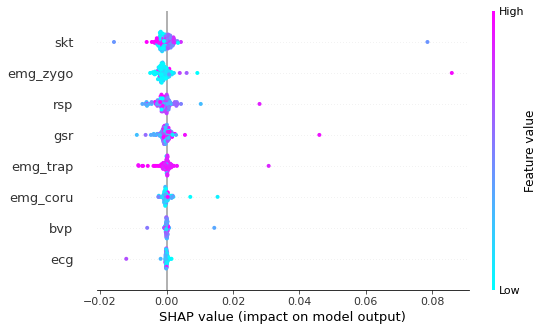

<Figure size 432x288 with 0 Axes>

FOR  Aroused or Astonished


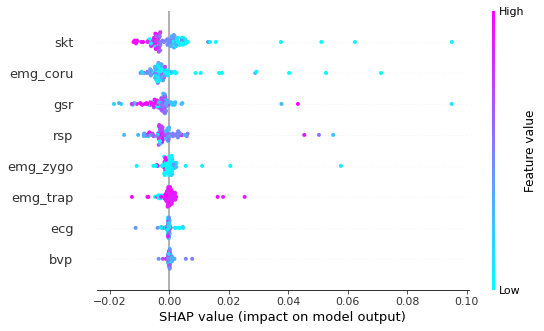

<Figure size 432x288 with 0 Axes>

FOR  Confident or Attentive


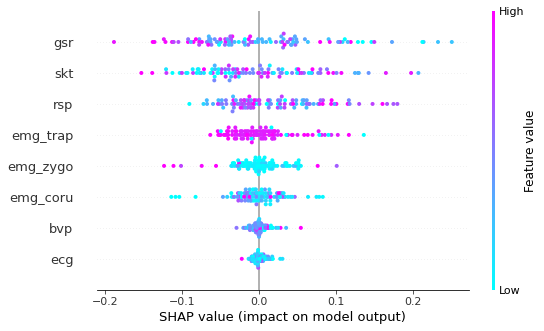

<Figure size 432x288 with 0 Axes>

FOR  Delighted or Happy


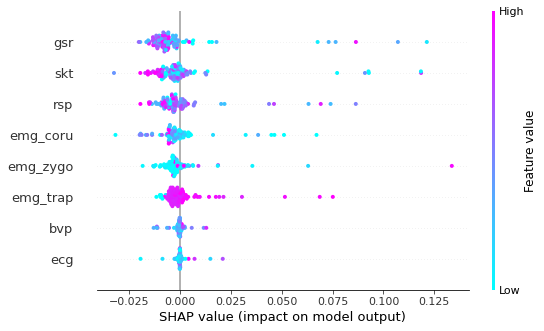

<Figure size 432x288 with 0 Axes>

FOR  Distressed or Defiant


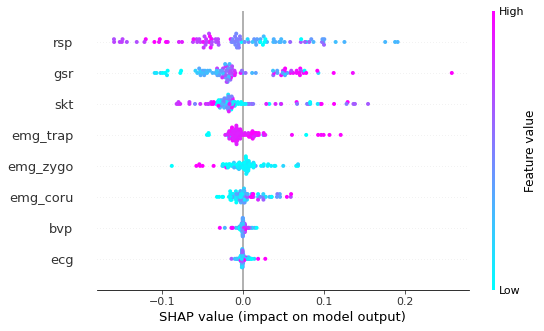

<Figure size 432x288 with 0 Axes>

FOR  Frustrated or Discontented


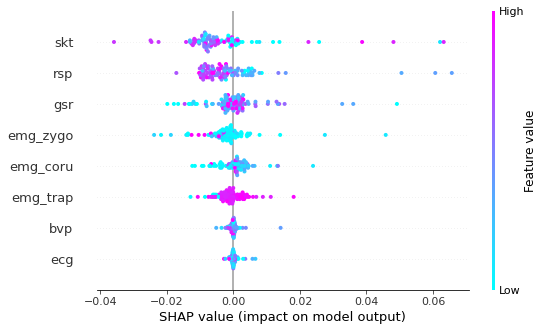

<Figure size 432x288 with 0 Axes>

FOR  Frustrated or Impatient


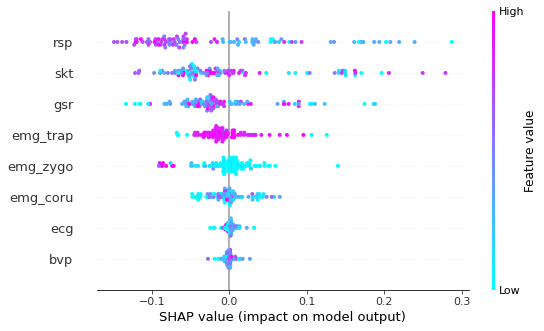

<Figure size 432x288 with 0 Axes>

FOR  Miserable or Sad


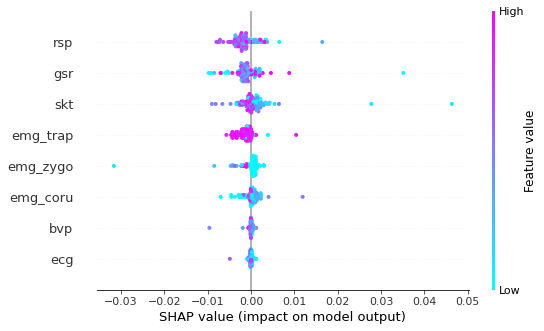

<Figure size 432x288 with 0 Axes>

FOR  Passionate or Amused


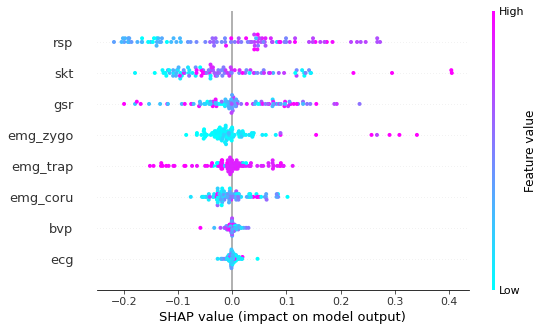

<Figure size 432x288 with 0 Axes>

FOR  Pleased or Glad


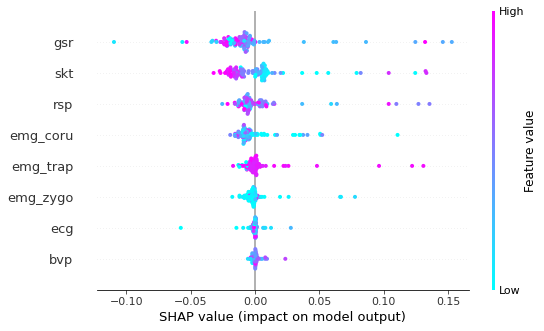

<Figure size 432x288 with 0 Axes>

FOR  Polite or Sleepy


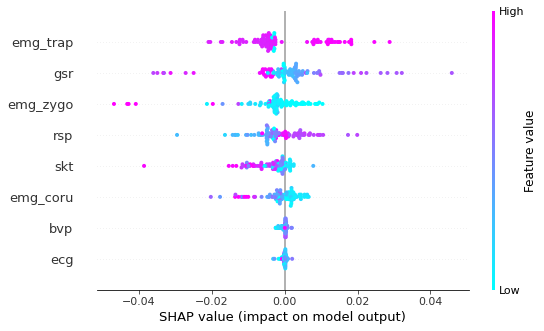

<Figure size 432x288 with 0 Axes>

FOR  Tensed or Annoyed


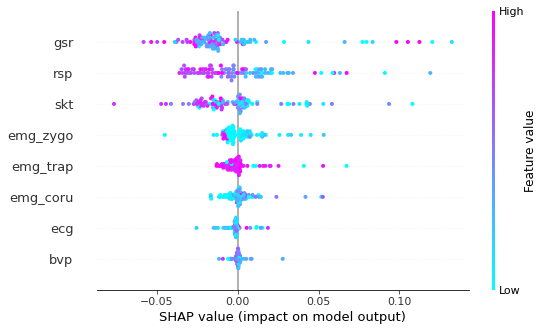

<Figure size 432x288 with 0 Axes>

FOR  Tired or Bored


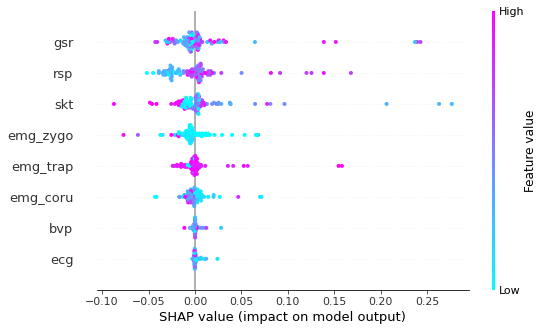

<Figure size 432x288 with 0 Axes>

FOR  Worried or Apathetic


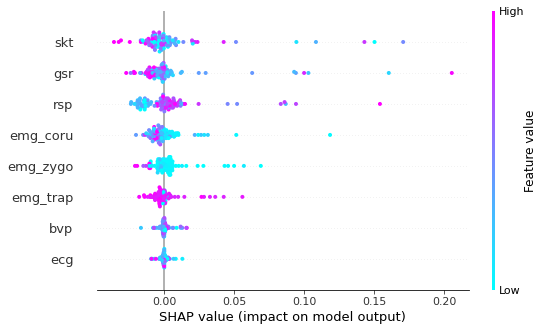

<Figure size 432x288 with 0 Axes>

In [25]:
class_names = encoded_classes

for i in range(0,len(class_names)):
    print("FOR ",class_names[i])
    shap.summary_plot(shap_values_RF_test[i],X_test[0:100],class_names=class_names,max_display = 8,cmap=colour_scheme)
    plt.tight_layout()
    plt.savefig('shap_summary_plot.png', bbox_inches='tight')
    plt.show()

FOR  Anxious or Dejected


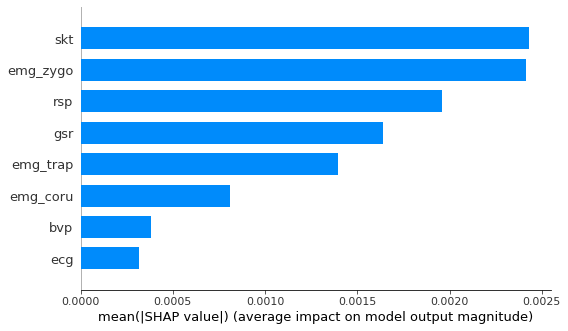

FOR  Aroused or Astonished


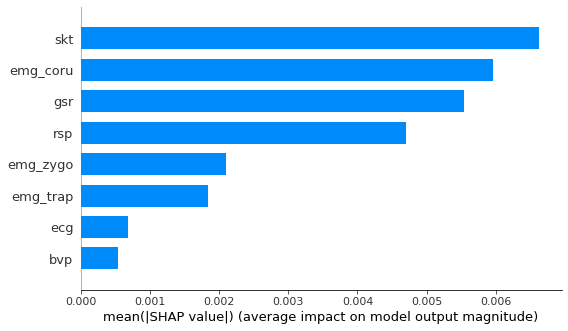

FOR  Confident or Attentive


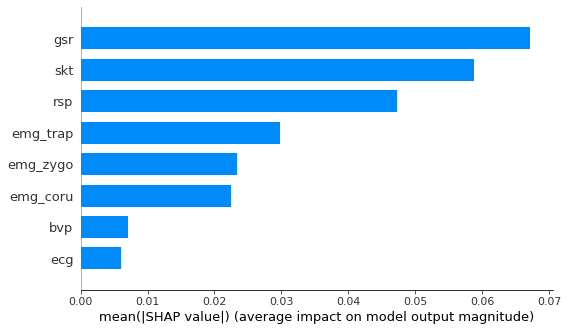

FOR  Delighted or Happy


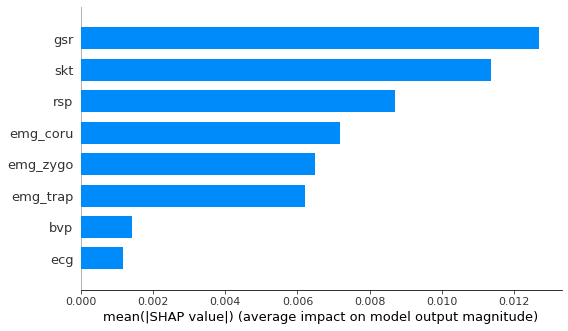

FOR  Distressed or Defiant


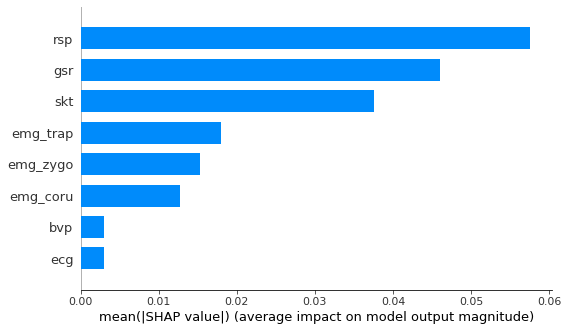

FOR  Frustrated or Discontented


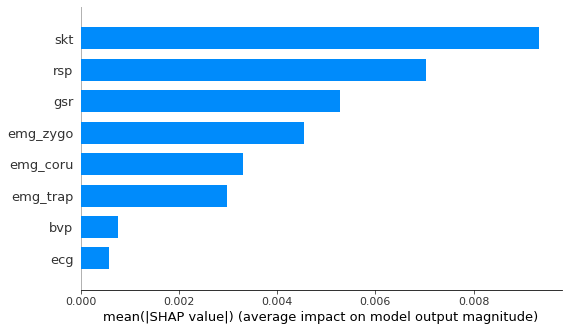

FOR  Frustrated or Impatient


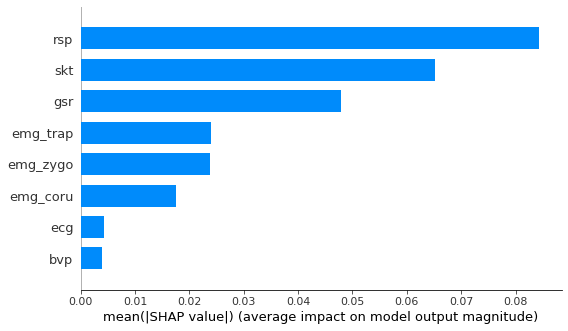

FOR  Miserable or Sad


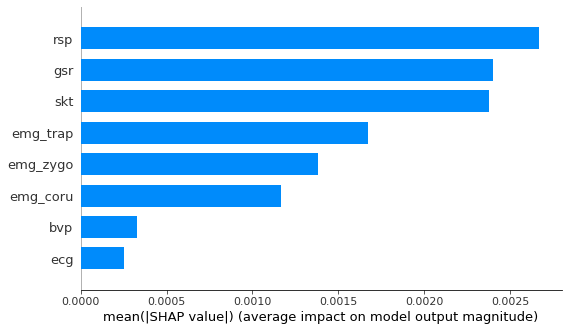

FOR  Passionate or Amused


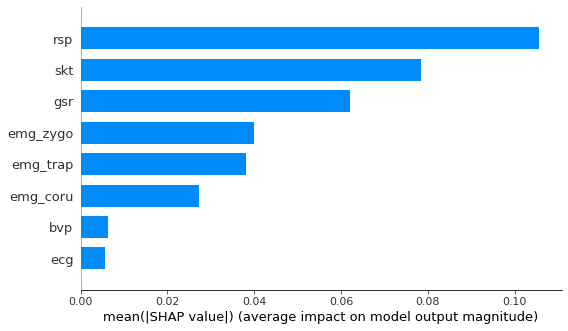

FOR  Pleased or Glad


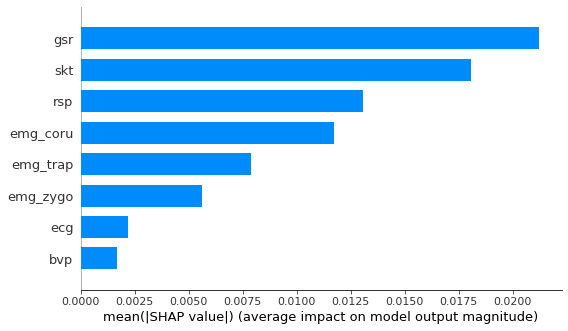

FOR  Polite or Sleepy


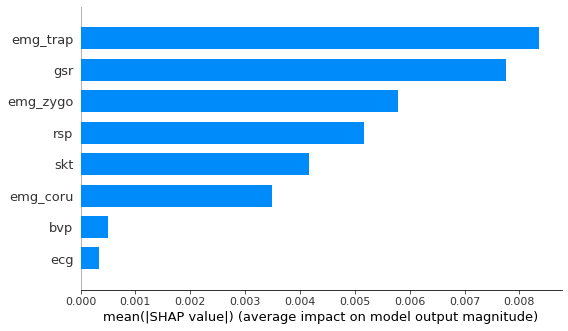

FOR  Tensed or Annoyed


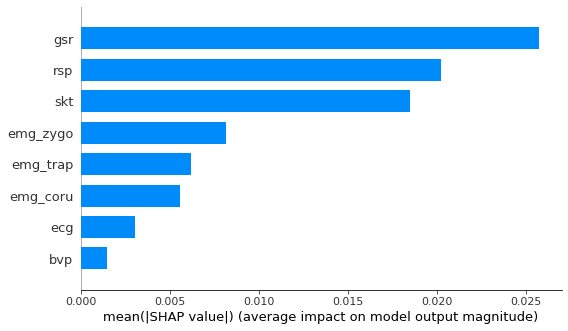

FOR  Tired or Bored


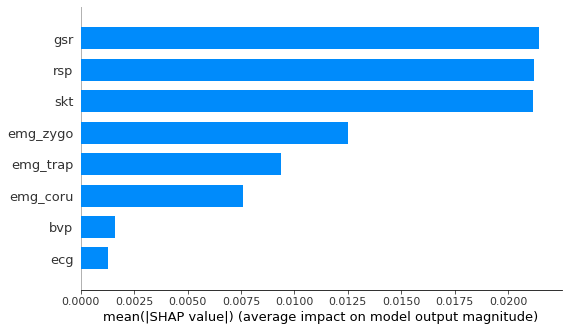

FOR  Worried or Apathetic


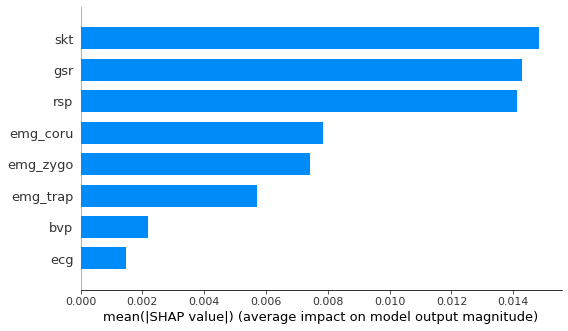

<Figure size 432x288 with 0 Axes>

In [26]:
class_names = encoded_classes

for i in range(0,len(class_names)):
    print("FOR ",class_names[i])
    shap.summary_plot(shap_values_RF_test[i],X_test[0:100],class_names=class_names,max_display = 8,plot_type="bar")

plt.tight_layout()

# Save or show the plot
plt.savefig('shap_summary_plot.png', bbox_inches='tight')
plt.show()

In [27]:
shap.initjs()
from IPython.display import display
print(X_test.iloc[1])
print(class_names[y_test[1]])

for i in range(len(class_names)):
    print("CLASS ",class_names[i])
    display(shap.force_plot(explainerRF.expected_value[i], shap_values_RF_test[i][instance_index][:], X_test.iloc[[instance_index]], plot_cmap="GnPR"))
    print("CLASS ",class_names[i])
    display(shap.force_plot(explainerRF.expected_value[i], shap_values_RF_test[i][:][:], X_test.iloc[0:100],plot_cmap="GnPR"))

ecg          0.691620
bvp         36.322411
gsr          9.296856
rsp         35.392372
skt         24.891522
emg_zygo     5.563250
emg_coru     5.358000
emg_trap    14.803500
Name: 401755, dtype: float64
Frustrated or Impatient
CLASS  Anxious or Dejected


CLASS  Anxious or Dejected


CLASS  Aroused or Astonished


CLASS  Aroused or Astonished


CLASS  Confident or Attentive


CLASS  Confident or Attentive


CLASS  Delighted or Happy


CLASS  Delighted or Happy


CLASS  Distressed or Defiant


CLASS  Distressed or Defiant


CLASS  Frustrated or Discontented


CLASS  Frustrated or Discontented


CLASS  Frustrated or Impatient


CLASS  Frustrated or Impatient


CLASS  Miserable or Sad


CLASS  Miserable or Sad


CLASS  Passionate or Amused


CLASS  Passionate or Amused


CLASS  Pleased or Glad


CLASS  Pleased or Glad


CLASS  Polite or Sleepy


CLASS  Polite or Sleepy


CLASS  Tensed or Annoyed


CLASS  Tensed or Annoyed


CLASS  Tired or Bored


CLASS  Tired or Bored


CLASS  Worried or Apathetic


CLASS  Worried or Apathetic


In [28]:
import time
start = time.time()
explanation = explainerRF(X_test[0:100])
end = time.time()
print(end-start)

151.89481949806213


In [29]:
# shap.plots.force(explanation[0])
np.array(explanation).shape
print(X_test)
feature_names = ['ecg','bvp','gsr','rsp','skt','emg_zygo','emg_coru','emg_trap']

            ecg        bvp        gsr        rsp        skt  emg_zygo  \
317397  0.86904  35.595940   6.647472  33.049947  25.406864   6.22025   
401755  0.69162  36.322411   9.296856  35.392372  24.891522   5.56325   
52931   0.78362  36.351480  14.047632  37.599274  24.540953   5.80975   
189523  0.82632  35.121355  12.845160  27.000322  29.147515  10.28600   
99534   0.74748  35.876835  36.638592  46.485039  28.439356   5.19375   
...         ...        ...        ...        ...        ...       ...   
423921  0.88546  34.947005  18.581568  33.340319  31.678664   5.19375   
317955  0.78690  36.293343   6.576504  32.294966  25.389343   6.05600   
213695  0.76718  37.194106  37.230000  42.748790  25.533075   4.98825   
138227  1.31258  35.595940  45.170424  46.446326  28.646193   5.11150   
186092  0.85590  37.000415   6.844608  32.469202  25.431407   6.38475   

        emg_coru  emg_trap  
317397   9.54675   8.23275  
401755   5.35800  14.80350  
52931    5.89175   7.37025  
189523 

CLASS NAME  Anxious or Dejected


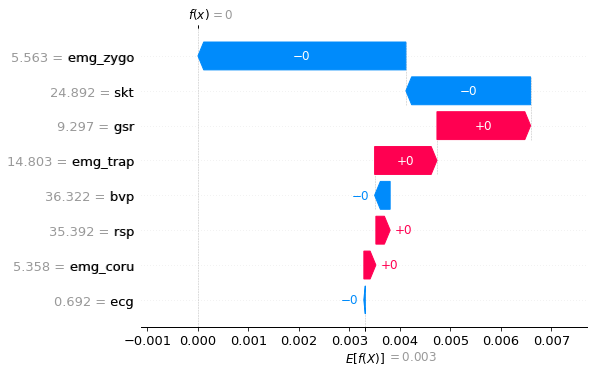

CLASS NAME  Aroused or Astonished


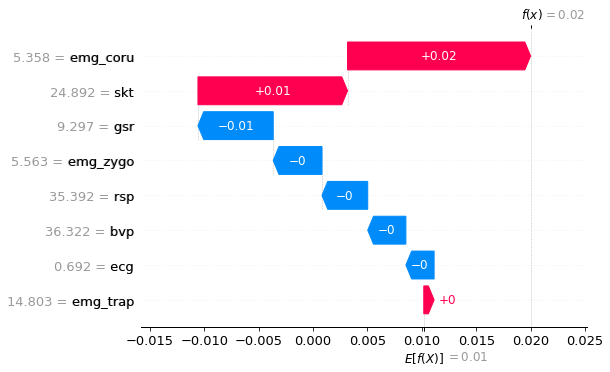

CLASS NAME  Confident or Attentive


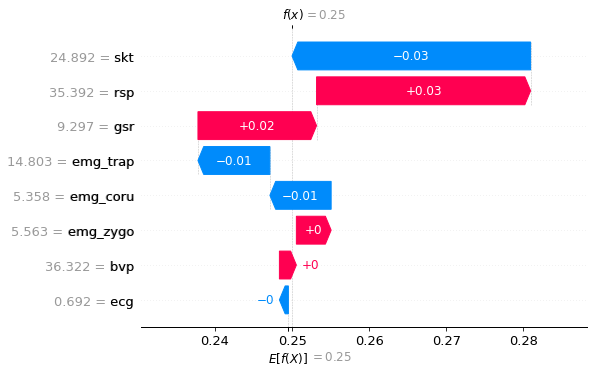

CLASS NAME  Delighted or Happy


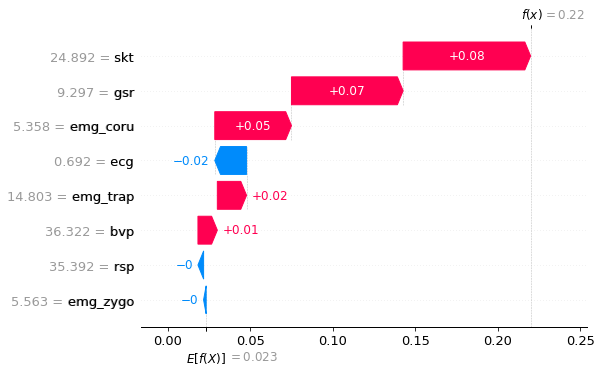

CLASS NAME  Distressed or Defiant


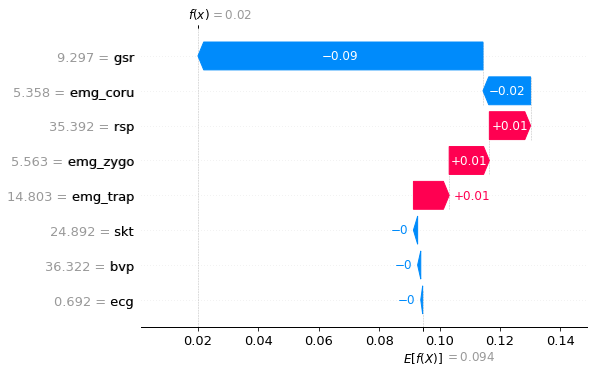

CLASS NAME  Frustrated or Discontented


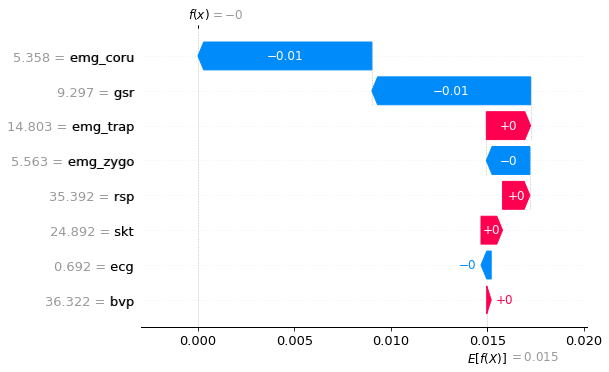

CLASS NAME  Frustrated or Impatient


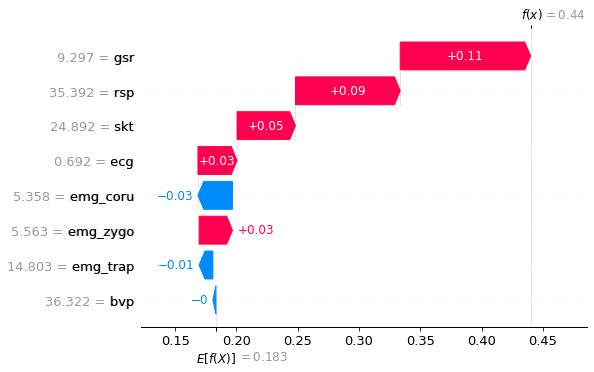

CLASS NAME  Miserable or Sad


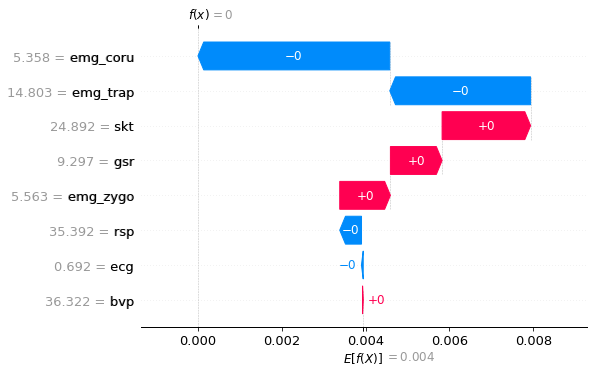

CLASS NAME  Passionate or Amused


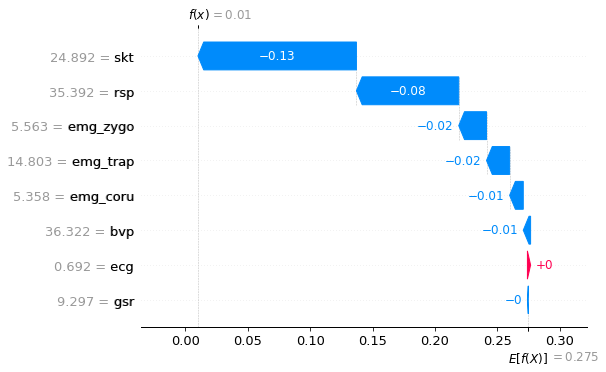

CLASS NAME  Pleased or Glad


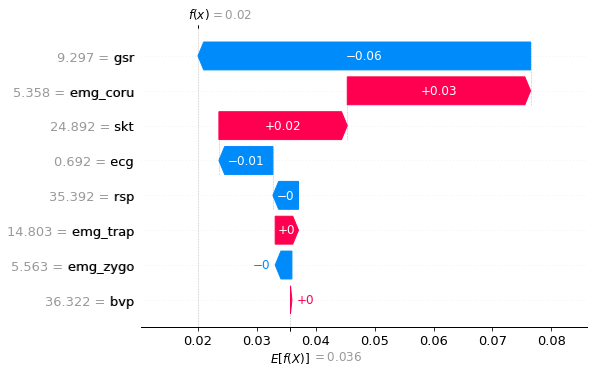

CLASS NAME  Polite or Sleepy


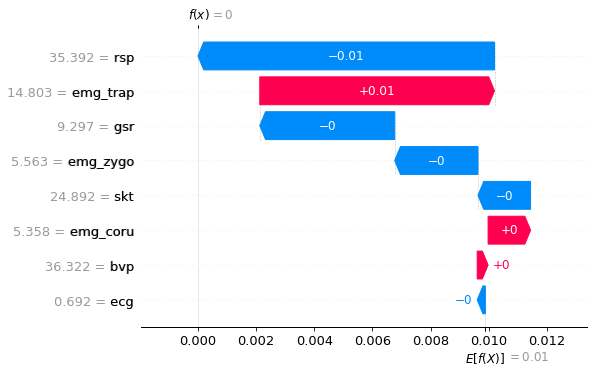

CLASS NAME  Tensed or Annoyed


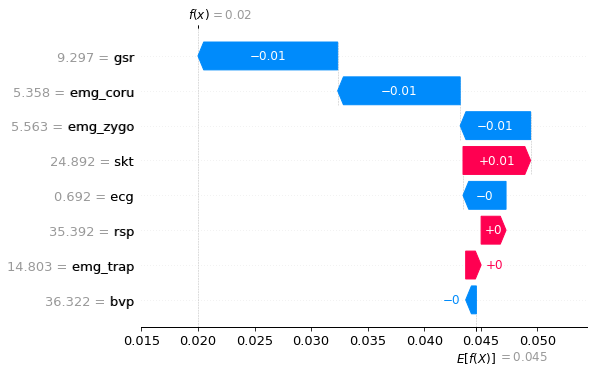

CLASS NAME  Tired or Bored


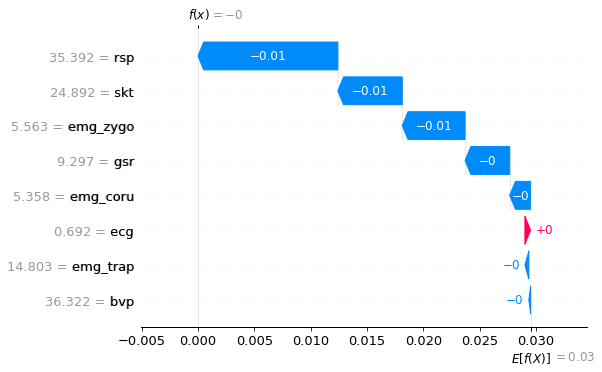

CLASS NAME  Worried or Apathetic


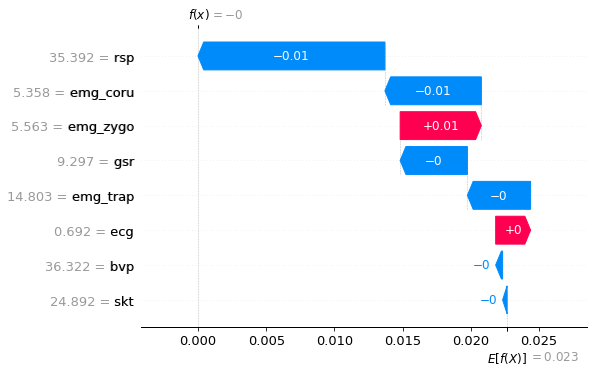

In [30]:
for i in range(len(class_names)):
    class_name = i
    print("CLASS NAME ", class_names[class_name])
    EXP = shap.Explanation(
        values=explanation[instance_index].values[:,class_name],
        base_values=explanation[instance_index].base_values[class_name],
        data = explanation[instance_index].data,
        feature_names = feature_names
    )
    shap.waterfall_plot(EXP,max_display = 8)

In [31]:
class_names[y_test[instance_index]]

'Frustrated or Impatient'

In [32]:
X_test.iloc[instance_index]

ecg          0.691620
bvp         36.322411
gsr          9.296856
rsp         35.392372
skt         24.891522
emg_zygo     5.563250
emg_coru     5.358000
emg_trap    14.803500
Name: 401755, dtype: float64

CLASS  Anxious or Dejected


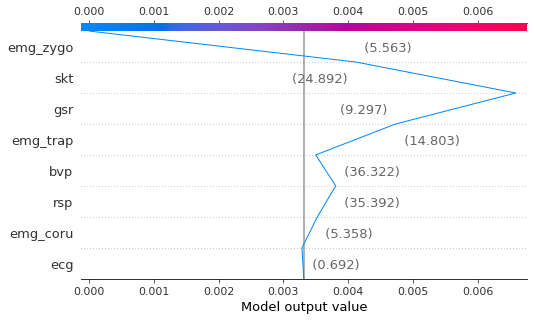

CLASS  Aroused or Astonished


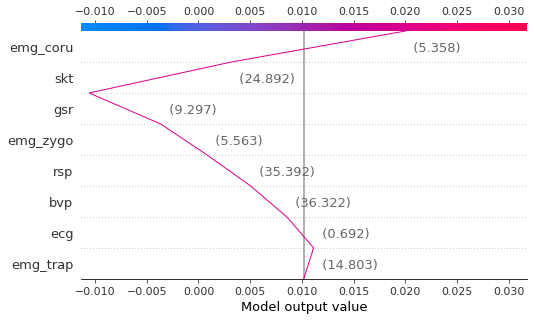

CLASS  Confident or Attentive


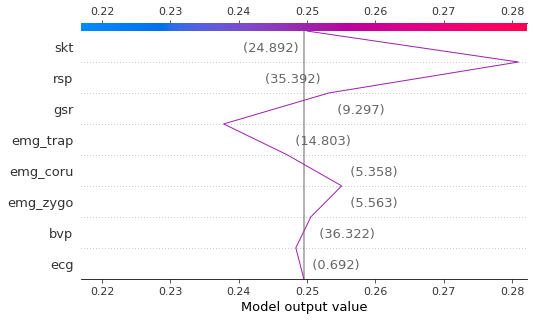

CLASS  Delighted or Happy


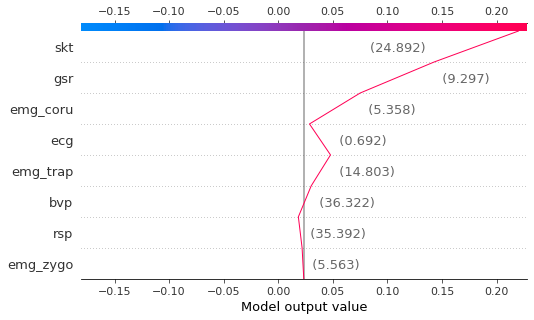

CLASS  Distressed or Defiant


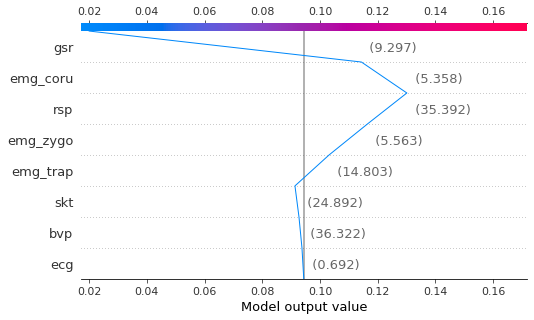

CLASS  Frustrated or Discontented


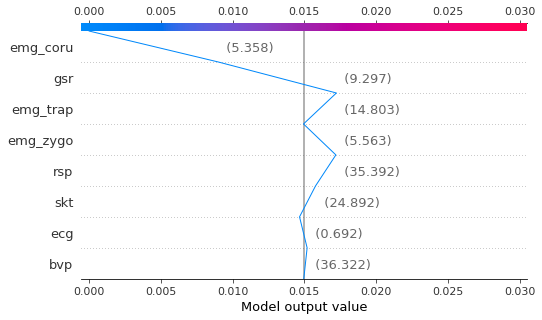

CLASS  Frustrated or Impatient


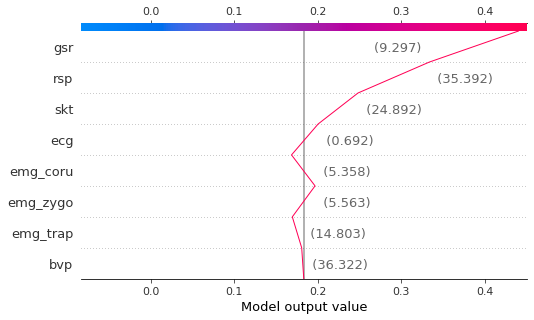

CLASS  Miserable or Sad


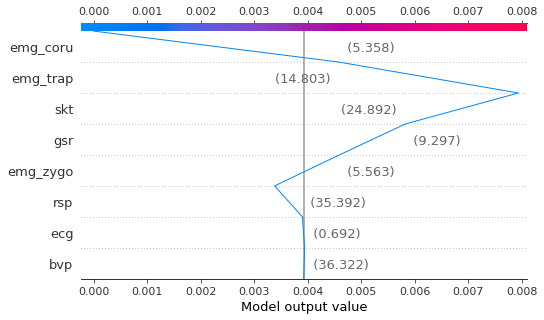

CLASS  Passionate or Amused


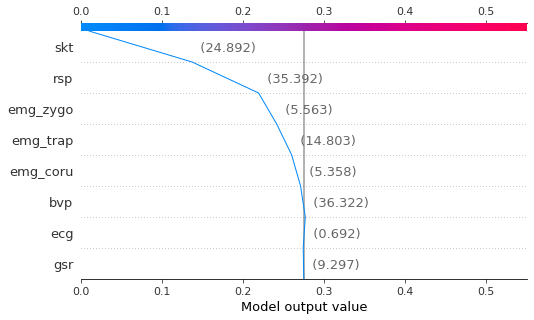

CLASS  Pleased or Glad


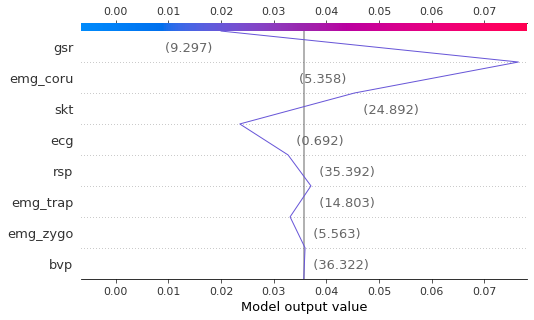

CLASS  Polite or Sleepy


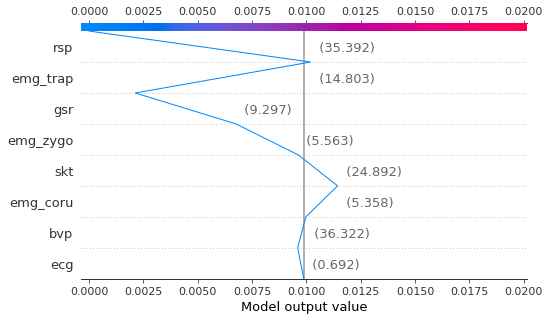

CLASS  Tensed or Annoyed


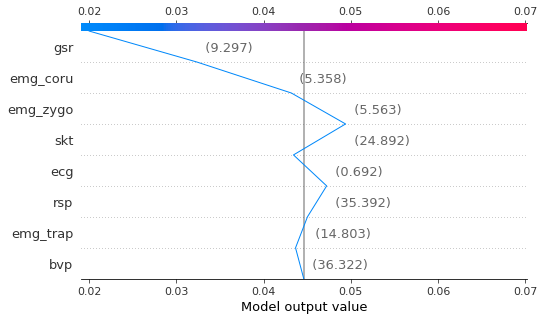

CLASS  Tired or Bored


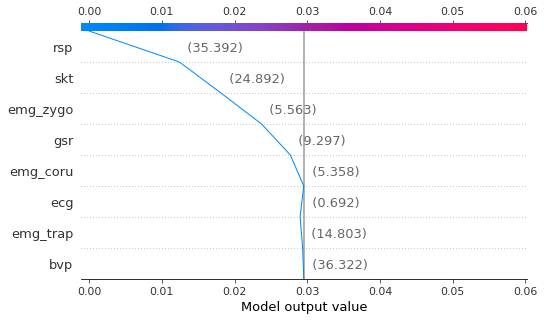

CLASS  Worried or Apathetic


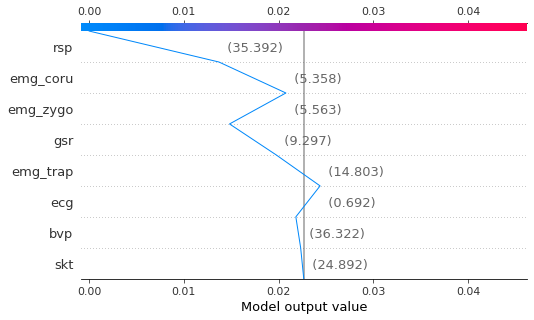

In [33]:
for i in range(len(class_names)):
    print("CLASS ",class_names[i])
    shap.decision_plot(explainerRF.expected_value[i], shap_values_RF_test[i][instance_index], X_test.iloc[instance_index])

In [34]:
explainer = lime.lime_tabular.LimeTabularExplainer(
    X_train.values, feature_names=X_train.columns, mode="classification",kernel_width=0.5)
t0 = time.time()

explanations_test = []

explanation_lime = explainer.explain_instance(
    X_test.values[instance_index], rf.predict_proba, num_features=10, top_labels=14)
explanations_test.append(explanation_lime)

t1 = time.time()
timeit = t1 - t0
print("TIME to interpret\n\n", timeit, "seconds")

X does not have valid feature names, but RandomForestClassifier was fitted with feature names


TIME to interpret

 10.342508316040039 seconds


In [61]:
explanation = explanations_test[0]
explanation.show_in_notebook()

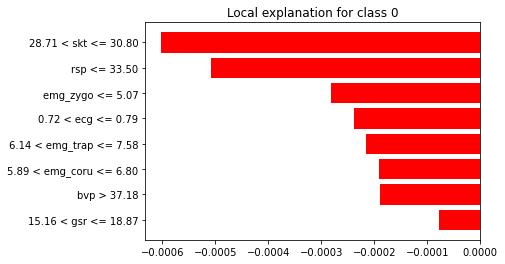

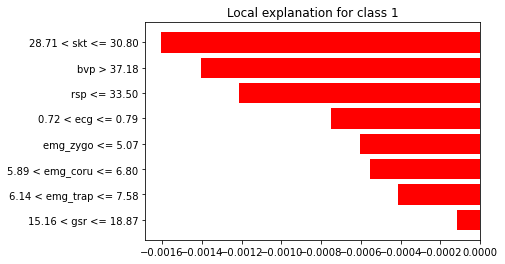

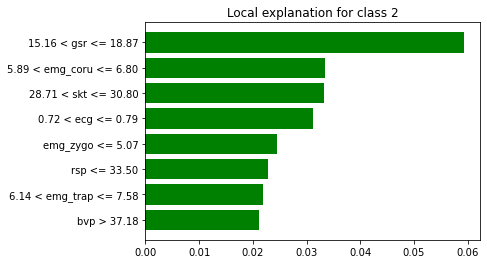

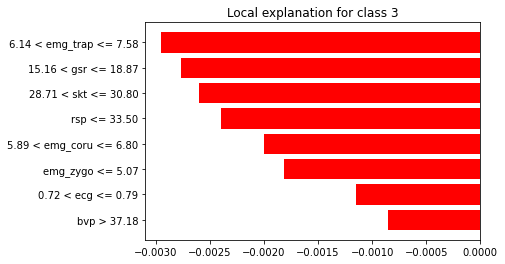

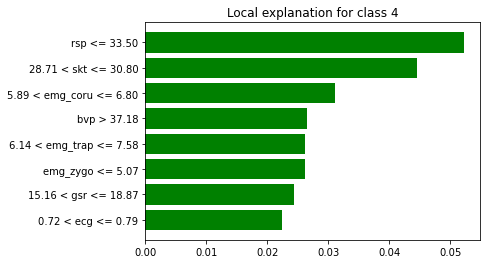

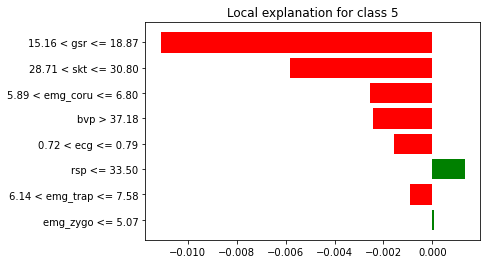

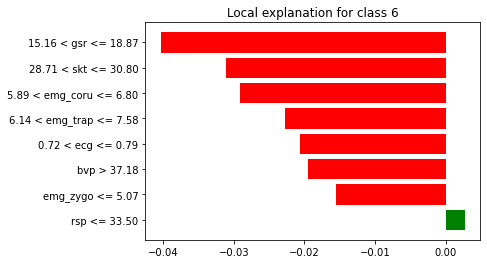

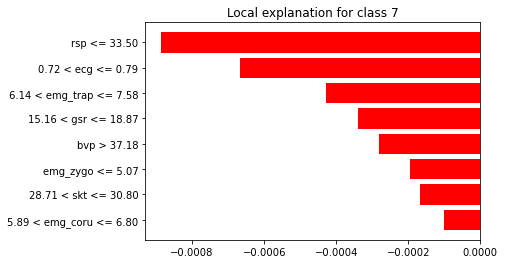

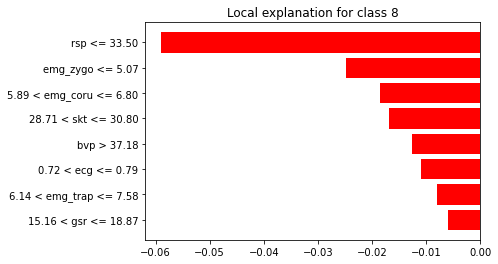

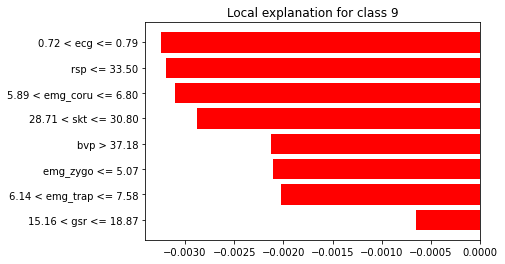

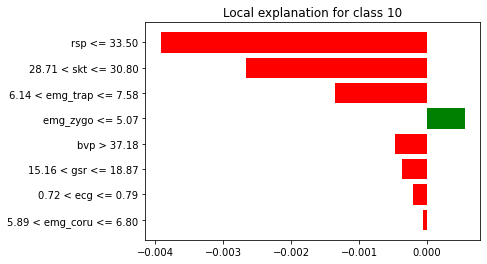

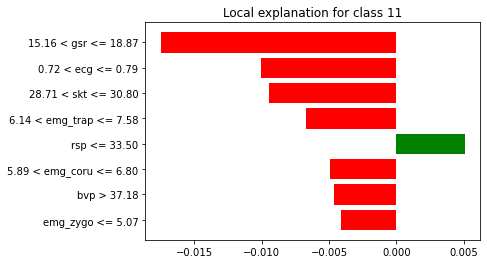

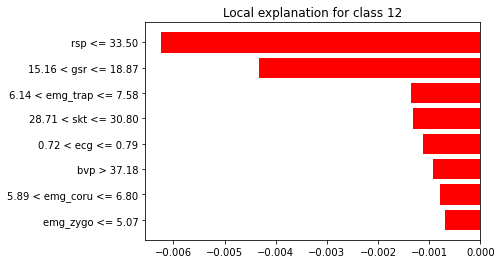

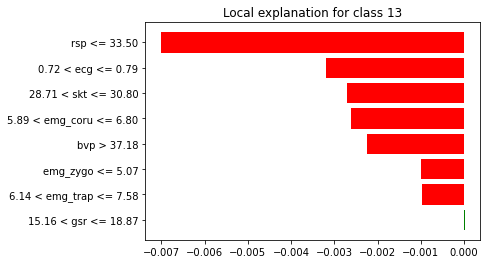

In [62]:
for i in range(len(encoded_classes)):
    explanation.as_pyplot_figure(label=i)